In [3]:
%pylab inline
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os
import anndata
import leidenalg
import skimage
import tifffile
import cv2
from skimage import exposure

# 1. Introduction

### Goal
__The goal of this script is to facilitate antibody titration in IMC__

This script helps identifying, for each tested marker, the positive and negative cells (based on clustering). The signal and noise are then calculated to help choosing the ideal concentration for each antibody. 

### Antibody titration 
For titration, an antibody mix is generated and a serial dilution is performed.  
Different sections (or different areas of the same section) are then stained with the different dilutions (relative concentrations).  
Finally, these sections are imaged by IMC.

### Image preprocessing
The `.mcd` files generated in IMC can be preprocessed using [steinbock](https://github.com/BodenmillerGroup/steinbock).  
Steinbock preprocessing allows to segment the images, measure single-cell marker inteisites and export the data to a readable format.  
This script assumes that IMC data preprocessing was performed with `steinbock` using default parameters. If other settings were used, part of this script may have to be adapted.
At the end of `steinbock` preprocessing, the data have to be exported in the `AnnData` format.

For reference, the following `steinbock` command can be used (adjust the path and steinbock version):
```
$ alias steinbock="docker run -v /path/to/your/data:/data -v /tmp/.X11-unix:/tmp/.X11-unix -v ~/.Xauthority:/home/steinbock/.Xauthority:ro -u $(id -u):$(id -g) -e DISPLAY ghcr.io/bodenmillergroup/steinbock:0.9.1"
$ steinbock preprocess imc images --hpf 50
$ steinbock segment deepcell --minmax
$ steinbock measure intensities
$ steinbock measure regionprops
$ steinbock export anndata --x intensities --obs regionprops
```

Full `steinbock` documentation can be found [here](https://bodenmillergroup.github.io/steinbock/latest/).  

### Script usage

It is expected that the mcd files and ROIs have been named in a consistent manner.
The mcd file names OR the ROI descriptions should contain one number corresponding to the relative concentration of the antibody mix.  

This script performs the following tasks:
1. Import data (exported by `steinbock` as `AnnData` object(s).
2. Calculate UMAP and generate some quality control plots.
3. Cluster the cells.
4. Facilitate the selection of clusters corresponding to positive and negative cells, for each marker.
5. Calculate the signal, noise, and signal-to-noise ratio.
6. Export the titration results.

__The steps 4 and 5 have to be repeated for each marker.__

# 2. Parameters

The mcd file names OR the ROI description are expected to contain a number corresponding to the dilution / relative concentration of the antibody mix that was used to stain the section or section area.  

__The naming schemes that were applied for naming the mcd(s) and ROIs should be indicated here.__  
Example: if three slides were used with a three-fold antibody-mix dilution series (1:1, 1:3, 1:9), the mcd files could be named: `XXX_1.00`, `XXX_0.33`, and `XXX_0.11`.  
The corresponding naming scheme would be: `mcdName_elements = ['slide_name', 'concentration']`.  
__Note__ the part of the name corresponding to the relative concentration should always be called `concentration`.

In [5]:
# Steinbock output directory
data_path = '/home/ubuntu/Data2/Pilot/titration/islet/'

# Parse the .mcd file name (scheme for naming the .mcd files)
mcdName_elements = ['donor_id', 'panel']
mcdName_separator = '_'

# Parse the ROI description (scheme for naming the different ROIs in the .mcd file)
roiName_elements = ['panel', 'concentration']
roiName_separator = '_'

# Parse the tiff file name (no change needed, only adds acquisition id to the list)
imgName_elements = mcdName_elements + ['acq_id']

__Parameter check__  
Adapt the parameters in the chunk above if you get any error message here

In [6]:
# Check if path exists
# Check if it contains the right folders and files (panel, images)
# Check that "concentration" is in the names and that it is a number

# 3. Data preparation

It is assumed that the defaults steinbock folder structure and file names were used. If changes were made, adapt the following chunk as needed.

## Load the data

### Load image acquisition metadata

In [7]:
image_metadata = pd.read_csv(os.path.join(data_path, 'images.csv'))
image_metadata

image  width_px  height_px  num_channels          source  \
0  6197_Islet_1.tiff       514        932            39  6197_Islet.mcd   
1  6197_Islet_2.tiff      1012        533            39  6197_Islet.mcd   
2  6197_Islet_3.tiff      1213        507            39  6197_Islet.mcd   
3  6301_Islet_1.tiff      1060        517            39  6301_Islet.mcd   
4  6301_Islet_2.tiff      1539        401            39  6301_Islet.mcd   
5  6301_Islet_3.tiff       737        621            39  6301_Islet.mcd   

   recovered  acquisition_id acquisition_description  acquisition_start_x_um  \
0      False               1                 Islet_1               18604.034   
1      False               2                 Islet_3               26083.173   
2      False               3                 Islet_9               31670.495   
3      False               1                 Islet_1               20065.153   
4      False               2                 Islet_3               20978.607   
5      False               3                 Islet_9               29609.786   

   acquisition_start_y_um  acquisition_end_x_um  acquisition_end_y_um  \
0               11130.913             19119.996             10204.118   
1               13845.601             27097.144             13316.002   
2               12951.861             32885.472             12448.145   
3                9078.183             21127.133              8564.508   
4               14498.742             22519.592             14100.540   
5               14002.421             30348.767             13385.213   

   acquisition_width_um  acquisition_height_um  
0               515.962                926.795  
1              1013.971                529.599  
2              1214.977                503.716  
3              1061.980                513.675  
4              1540.985                398.202  
5               738.981                617.208

### Load antibody panel

In [8]:
panel = pd.read_csv(os.path.join(data_path, 'panel.csv'))
panel

number channel  tubeNb species                   target          vendor  \
0        0   In115     NaN     NaN               Hyaluronan           Merck   
1        1   Pr141  2228.0  rabbit                     WFS1           LSBio   
2        2   Nd142  1677.0  rabbit           Chromogranin_A           Abcam   
3        3   Nd143  2193.0  rabbit            Complement_C3           Abcam   
4        4   Nd144  1132.0  rabbit  Proprotein_Convertase_2       Millipore   
5        5   Nd145  2194.0  rabbit                    XBP1           Thermo   
6        6   Nd146  1676.0  rabbit            Synaptophysin           Abcam   
7        7   Sm147  2141.0  rabbit                   HIF_1a           Abcam   
8        8   Nd148  1048.0  rabbit                  p_STAT1             CST   
9        9   Sm149  2195.0  rabbit                   IRE1?            Novus   
10      10   Nd150  1756.0   mouse                 Amylase            Sigma   
11      11   Eu151  2196.0  rabbit                  PFKFB3            Abcam   
12      12   Sm152  1758.0  rabbit                C_Peptide             CST   
13      13   Eu153  2197.0  rabbit                   p_NRF2           Abcam   
14      14   Sm154  1051.0   mouse               Proinsulin           Abcam   
15      15   Gd155  1760.0  rabbit                     Pdx1           Abcam   
16      16   Gd156   922.0  rabbit              Proglucagon             CST   
17      17   Gd158  2180.0   mouse                   TXNIP            Novus   
18      18   Tb159  2198.0   mouse                Perlecan            Sigma   
19      19   Gd160  2038.0  rabbit              PD_L1_CD274           Abcam   
20      20   Dy161  2242.0   mouse                    PTPRN     R&D Systems   
21      21   Dy162  1855.0   mouse            CD45RO_CD45RA       Biolegend   
22      22   Dy163  2181.0  rabbit                    NFkB              CST   
23      23   Dy164  1608.0  rabbit                    IDO1            Abcam   
24      24   Ho165  2182.0  rabbit                    IkBa            Abcam   
25      25   Er166  1761.0   mouse                 ST8SIA1        Millipore   
26      26   Er167  2249.0  rabbit               Collagen_I           Abcam   
27      27   Er168  2015.0    goat                   LYVE1      R&D Systems   
28      28   Tm169  1124.0  rabbit                   Nkx6_1             CST   
29      29   Er170  2035.0   mouse          Cytokeratin_19            Sigma   
30      30   Yb171  1849.0  rabbit                PVR_CD155             CST   
31      31   Yb172  1888.0  rabbit                     p21        CST_Abcam   
32      32   Yb173  1152.0   mouse              E_Cadherin   BD Biosciences   
33      33   Lu175  2122.0  rabbit                     p_Rb             CST   
34      34   Yb176  1679.0  rabbit  Somatostatin_Receptor_2           Abcam   
35      35   Ir191     NaN     NaN               Iridium191             NaN   
36      36   Ir193     NaN     NaN               Iridium193             NaN   
37      37   Pt195  1876.0     rat                  Ghrelin     R&D Systems   
38      38   Pt196  1889.0   mouse             Somatostatin          Thermo   

            clone  stock  concentration  full  spill  seg_cells  seg_islets  \
0             NaN    NaN            NaN     1      1          0           0   
1             pAb  200.0           4.00     1      1          0           0   
2         EP1030Y  500.0           1.00     1      1          2           1   
3        EPR19394  500.0           2.00     1      1          0           0   
4             pAb  200.0           1.50     1      1          0           0   
5             pAb  500.0           5.00     1      1          0           0   
6           YE269  500.0           3.00     1      1          0           1   
7         EP1215Y  500.0           0.75     1      1          0           0   
8             pAb  200.0           7.50     1      1          0           0   
9             pAb  500.0           7.50     1      1 

### Load AnnData files
__List files__

In [9]:
anndata_extension = '.h5ad'
anndata_path = os.path.join(data_path, 'anndata')
anndata_files = [f for f in os.listdir(anndata_path) if f.endswith(anndata_extension)]

if len(anndata_files) < 1:
    print("Error: No AnnData files found")
else:
    print('List of anndata files found:', anndata_files)

List of anndata files found: ['6197_Islet_3.h5ad', '6197_Islet_2.h5ad', '6197_Islet_1.h5ad', '6301_Islet_1.h5ad', '6301_Islet_3.h5ad', '6301_Islet_2.h5ad']


__Read-in AnnData files__

In [10]:
ad = []

for i,file in enumerate(anndata_files):
    # Read the anndata files
    ad.append(anndata.read_h5ad(os.path.join(anndata_path, file)))
    
    # Extract info from file names and add to the anndata observations
    imgName_values = file.strip(anndata_extension).split(mcdName_separator)
    imgName = dict(zip(imgName_elements, imgName_values))
    
    for valname, val in imgName.items():
        ad[i].obs[valname] = val
    
    # Add image and object ids as explicit observations
    ad[i].obs['image_id'] = '_'.join(imgName_values)
    ad[i].obs['image'] = '_'.join(imgName_values) + '.tiff'
    ad[i].obs['object_id'] = ad[i].obs_names
        
    # Make observation names unique
    ad[i].obs_names =  ad[i].obs['image_id'] + '_' + ad[i].obs['object_id']

__Concatenate AnnData files__  
AnnData files corresponding to different .mcd files are merged into a single file

In [11]:
ad = anndata.concat(ad)

### Import image metadata
__Add image metadata to the AnnData file observations__

In [12]:
ad.obs = ad.obs.merge(image_metadata, how='left', on='image').set_index(ad.obs.index)

__Parse ROI descriptions__

In [129]:
ad.obs[roiName_elements] = ad.obs['acquisition_description'].str.split('_', expand = True)
ad.obs['concentration'] = ad.obs['concentration'].astype('double')

__Check that the correct concentrations were extracted from the parsed names__

In [14]:
concentrations = np.unique(ad.obs['concentration'])
print('Relative concentrations used = ', concentrations)

Relative concentrations used =  [1. 3. 9.]


### Import antibody panel
__Add panel to the AnnData file variables__

In [15]:
if len(ad.var) == len(panel):
    ad.var = panel
    ad.var_names = ad.var['name']
    markers = ad.var_names
    ad.var['number'] = list(range(len(panel)))
else:
    print("Different number of rows in the panel and in ad.var")

### Transform the data
Arcinh- and log-transformation are applied and stored in the `layers` of the AnnData object.

In [16]:
ad.layers['exprs'] = np.arcsinh(ad.X)
ad.layers['log'] = np.log1p(ad.X)

# 4. Dimensionality reduction

## Run PCA and UMAP

In [21]:
# Run PCA
sc.pp.pca(ad)

# Find nearest-neighbors
sc.pp.neighbors(ad, n_neighbors=30)

# Run UMAP
sc.tl.umap(ad)

## Plot UMAP
### Plot variables on UMAP
__Select in the list below the variables you want to visualize on UMAP.__  
The concentration is always plotted by default.

In [22]:
w_obs = widgets.SelectMultiple(
    options=ad.obs.columns[~ad.obs.columns.isin(['concentration'])],
    # value=[],
    rows=15,
    description='Observations',
    disabled=False
)
w_obs

SelectMultiple(description='Observations', options=('area', 'centroid-0', 'centroid-1', 'major_axis_length', '…

In [23]:
plot_variables = np.array(w_obs.value + ('concentration',))
ad.obs[plot_variables] = ad.obs[plot_variables].astype('category')

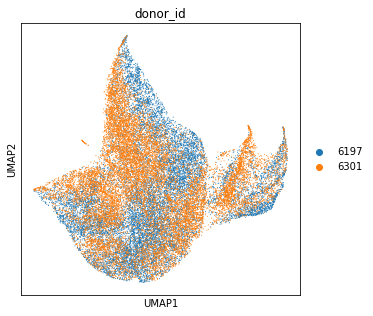

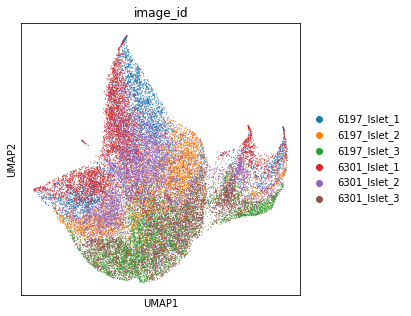

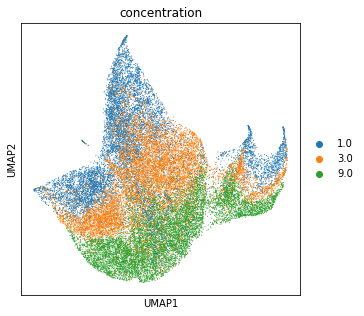

In [25]:
figsize(5,5)
for var in plot_variables:
    sc.pl.umap(ad, color=var)

### Plot channels on UMAP

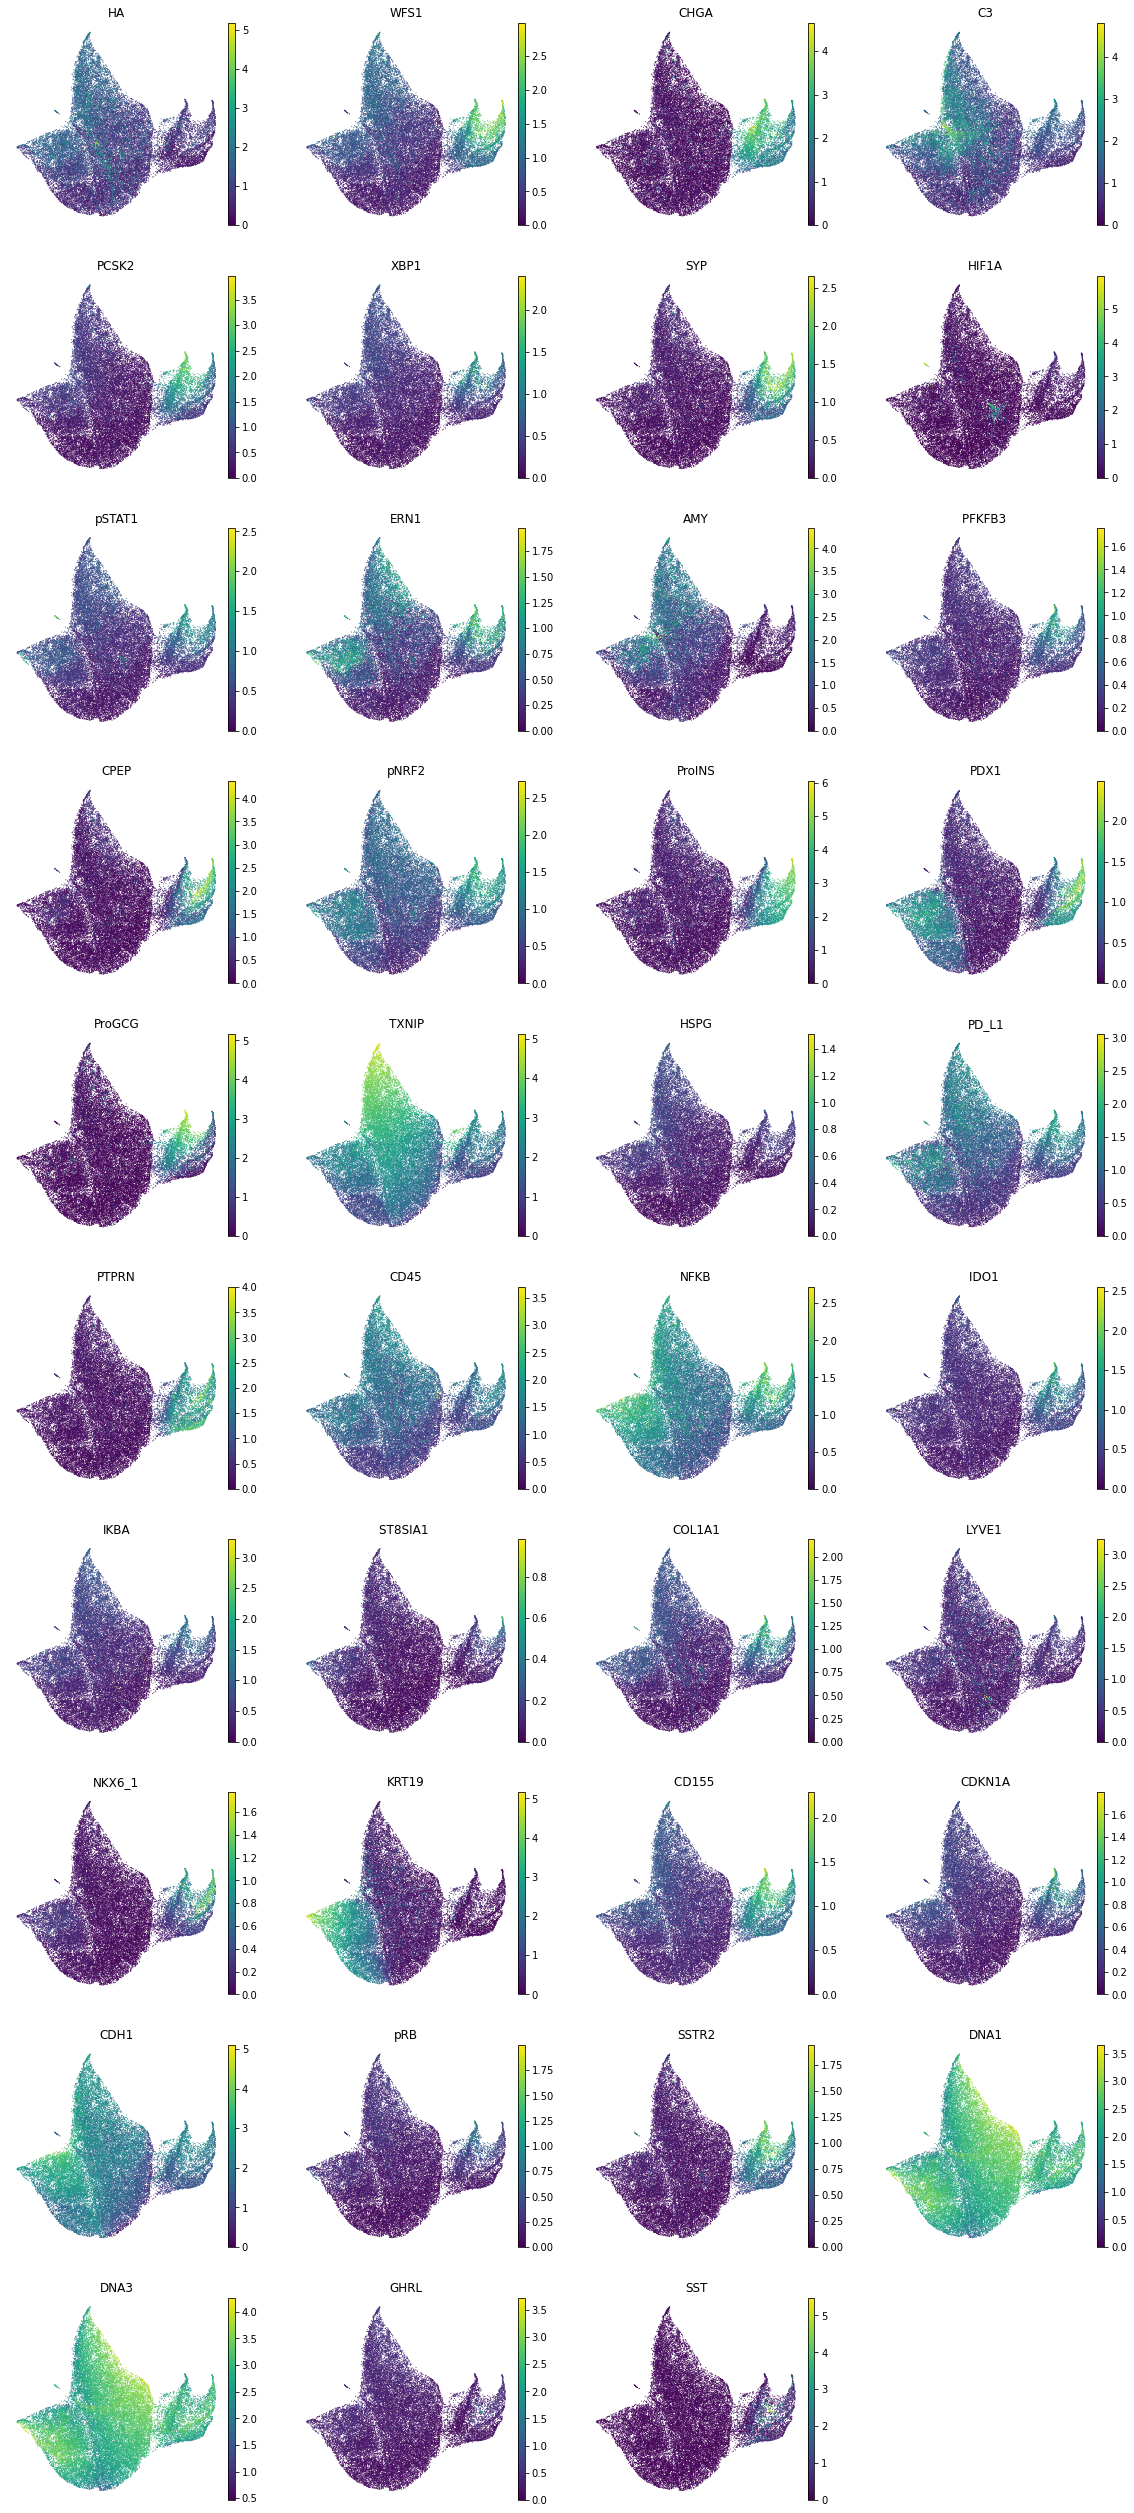

In [24]:
figsize(4,4)
sc.pl.umap(ad, layer='exprs', color=ad.var_names, gene_symbols = ad.var_names, frameon=False)

# 5. Clustering
### Run clustering and plot 
__Leiden community detection__

In [26]:
cluster_name = 'leiden_1'
sc.tl.leiden(ad, resolution=1.0, key_added=cluster_name)
ad.obs[cluster_name] = ad.obs[cluster_name].str.zfill(2).astype('category')

### Plot clusters
__Plot clusters on UMAP__

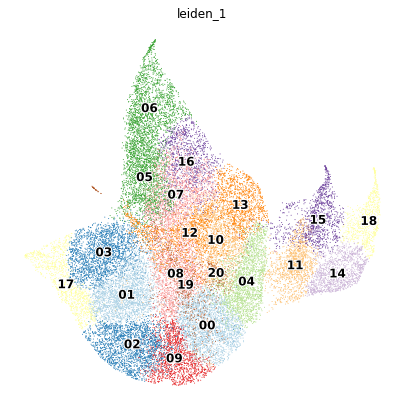

In [27]:
figsize(7,7)
sc.pl.umap(ad, color=cluster_name, add_outline=False, legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2,frameon=False, palette='Paired')

__Cluster heatmap__

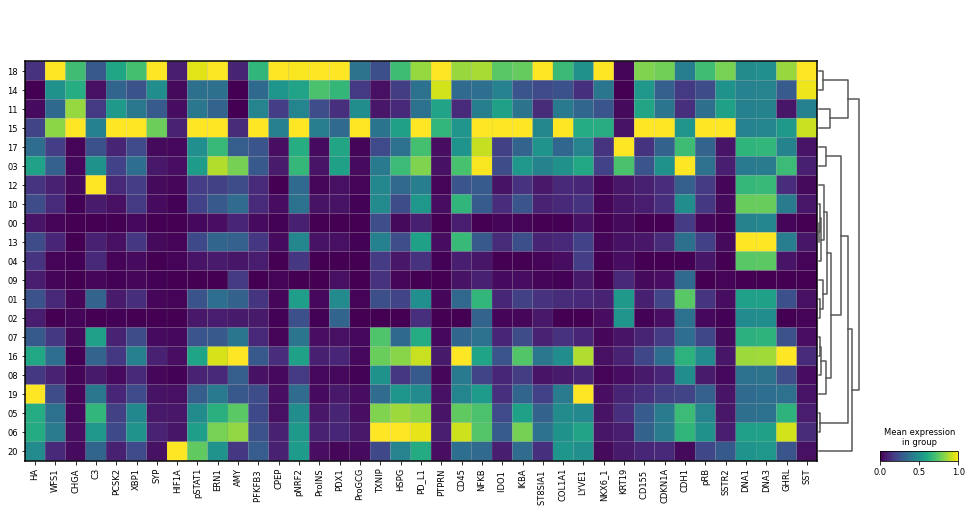

In [28]:
# Run dendrogram
sc.tl.dendrogram(ad, groupby=cluster_name, optimal_ordering=True)

# Plot heatmap
sc.pl.matrixplot(ad, ad.var_names, groupby=cluster_name, layer='exprs',
                 standard_scale = 'var', dendrogram=True)

### Calculate concentration distribution by cluster

In [29]:
cluster_distrib = ad.obs.groupby(['concentration', cluster_name]).size().to_frame('cellspercluster').reset_index()
cluster_total = ad.obs.groupby(['leiden_1']).size().to_frame('totalcells').reset_index()
cluster_distrib = pd.merge(cluster_distrib, cluster_total, on=cluster_name)
cluster_distrib['fraction'] = cluster_distrib['cellspercluster'] / cluster_distrib['totalcells']

## Write / read the AnnData object
Execute only if needed

In [131]:
# # Exported AnnData file name
# anndata_fn = os.path.join(data_path, 'titration.h5ad')

# # Write the file
# anndata.AnnData.write(ad, filename = anndata_fn)

# # Read the file (if saved in a previous run)
# ad = anndata.read_h5ad(anndata_fn)

# # Print-out the AnnData object
# ad

# 6. Identify positive and negative cells

## Select the highest- and lowest-expressing clusters

### Select the marker to analyze
___Only one marker can be analyzed at a time___

In [30]:
w_marker = widgets.Select(
    options=sorted(ad.var_names),
    value=sorted(ad.var_names)[0],
    rows=20,
    description='Markers:',
    disabled=False
)
w_marker

Select(description='Markers:', options=('AMY', 'C3', 'CD155 ', 'CD45', 'CDH1', 'CDKN1A', 'CHGA', 'COL1A1', 'CP…

In [353]:
cur_marker = w_marker.value
print("The current marker is:", cur_marker)

The current marker is: pRB


### Plot the clusters by expression level
__Calculate the mean expression level for the current marker__

In [354]:
# Calculate mean expression
cur_dat = sc.get.obs_df(ad, keys=[cluster_name, cur_marker], layer='exprs')
grouped = cur_dat.groupby(cluster_name)
mean, var = grouped.mean(), grouped.var()
mean_exprs = mean.sort_values(by=cur_marker)

# Order the cluster distribution by expression level
cluster_distrib[cluster_name] = pd.Categorical(cluster_distrib[cluster_name], categories=array(mean_exprs.index), ordered=True)
cluster_distrib.sort_values(cluster_name, inplace=True)

__Plot the cluster distribution by concentration + Plot the clusters by increasing expression level__

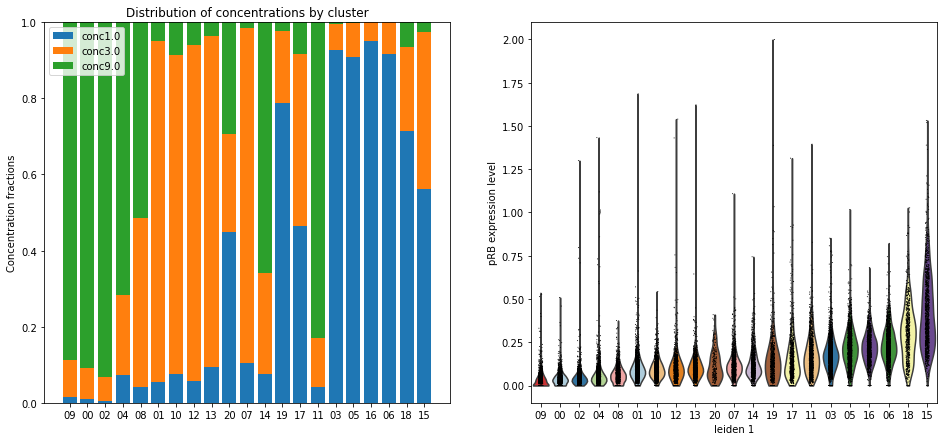

In [355]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,7))
labels = cluster_distrib[cluster_name].unique()
conc_list = []

for i,conc in enumerate(concentrations):
    conc_list.append(np.array(cluster_distrib[
        cluster_distrib['concentration'].astype(int) == int(concentrations[i])]['fraction']))

    if i == 0:
        ax1.bar(labels, conc_list[i], label='conc' + str(concentrations[i]))
    else:
        cur_conc_list = conc_list[0:i]
        ax1.bar(labels, conc_list[i], label='conc' + str(concentrations[i]),
               bottom = np.sum(cur_conc_list, axis=0))

ax1.set_ylabel('Concentration fractions')
ax1.set_title('Distribution of concentrations by cluster')
ax1.legend()

sc.pl.violin(adata=ad, keys=cur_marker, groupby=cluster_name, layer='exprs',
             order=mean_exprs.index.values, ylabel=(cur_marker + " expression level"),
             cmap='viridis_r', ax=ax2)

plt.show()

### Select the clusters

__Select clusters that are ***negative*** for the current marker__  
By default, the lowest-expressing cluster is selected.

In [356]:
w_neg = widgets.SelectMultiple(
    options=mean_exprs.index.values,
    value=(mean_exprs.index.values[0],),
    rows=20,
    description='Negative clusters:',
    disabled=False
)
w_neg

SelectMultiple(description='Negative clusters:', index=(0,), options=('09', '00', '02', '04', '08', '01', '10'…

__Select clusters that are ***positive*** for the current marker__   
By default, the highest-expressing cluster is selected.

In [357]:
w_pos = widgets.SelectMultiple(
    options=mean_exprs.index.values,
    value=(mean_exprs.index.values[-1],),
    rows=10,
    description='Positive clusters:',
    disabled=False
)
w_pos

SelectMultiple(description='Positive clusters:', index=(20,), options=('09', '00', '02', '04', '08', '01', '10…

__Add a column to identify positive and negative cells__

In [358]:
# Recover the selected clusters from the interactive widgets
clusters_neg = np.array(w_neg.value)
clusters_pos = np.array(w_pos.value)

# Add a 'cluster_selection' column
ad.obs.loc[:,('cluster_selection')] = 'Inter'
ad.obs.loc[ad.obs[cluster_name].isin(clusters_neg), 'cluster_selection'] = 'Negative'
ad.obs.loc[ad.obs[cluster_name].isin(clusters_pos), 'cluster_selection'] = 'Positive'

### Plot the selected clusters

/home/ubuntu/miniconda3/envs/titration_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster_selection' as categorical


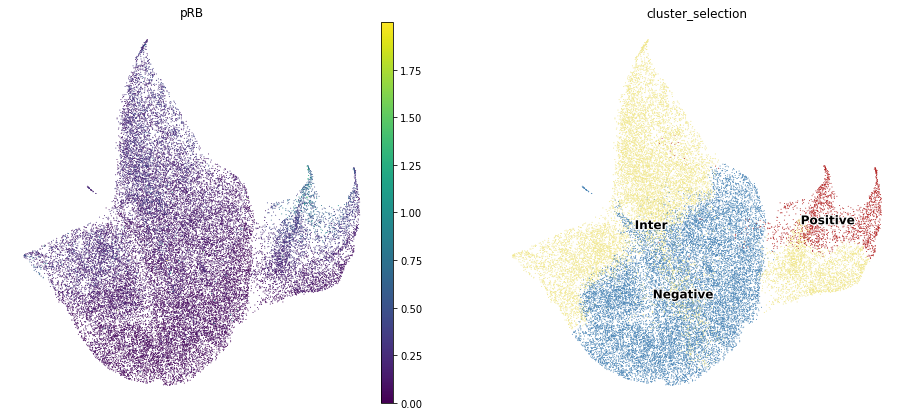

In [359]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
palette_dict = {'Negative': 'steelblue', 'Inter': 'khaki', 'Positive': 'firebrick'}

ax1_dict = sc.pl.umap(ad, layer='exprs', gene_symbols = cur_marker,
                      color=cur_marker, frameon=False, ax=ax1, show=False)
ax2_dict = sc.pl.umap(ad, color='cluster_selection', add_outline=False,
                      legend_loc='on data', legend_fontsize=12, legend_fontoutline=2,
                      frameon=False,palette=palette_dict, ax=ax2, show=False)

## Visualize the selected clusters on images

### Import images

Image importation is based on default steinbock folder and file names. If other names were used, the script should be adapted.

__List existing images and masks__

In [360]:
img_folder = os.path.join(data_path, 'img')
mask_folder = os.path.join(data_path, 'masks')
img_extension = ('tif', 'tiff')

# test if the folders exist

In [361]:
img_files = [f for f in os.listdir(img_folder) if f.endswith(img_extension)]
mask_files = [f for f in os.listdir(mask_folder) if f.endswith(img_extension)]

# test if images and masks are found
# test if len(img_files) == len(mask_files)

In [362]:
# Get the channel corresponding to the curent marker
channel = ad.var.loc[ad.var_names == cur_marker, 'number'].iloc[0]
# test if channel is int and print it

__Select one random image per concentration__  
Use the seed to always display the same images

In [363]:
# np.random.seed(1)
selected_images = []

for i,conc in enumerate(concentrations):
    cur_images = ad.obs[['concentration', 'image_id']][ad.obs['concentration'] == concentrations[i]].drop_duplicates()
    selected_images.append(np.random.choice(cur_images['image_id']))

__Load the images__

In [364]:
# Store image paths
image_paths = []
mask_paths = []

for i, conc in enumerate(concentrations):
    image_paths.append(os.path.join(img_folder, [f for f in img_files if f.startswith(selected_images[i])][0]))
    mask_paths.append(os.path.join(mask_folder, [f for f in img_files if f.startswith(selected_images[i])][0]))

In [365]:
image_list = []
mask_list = []

for i, conc in enumerate(concentrations):
    # Load the images
    image_list.append(tifffile.imread(image_paths[i]))
    mask_list.append(tifffile.imread(mask_paths[i]))
    
    if image_list[i].shape[0] != len(ad.var_names):
        print("The panel and image have a different number of channels")
        
    # Subset the channel corresponding to the curent marker
    image_list[i] = image_list[i][channel]
    
    if image_list[i].shape != mask_list[i].shape:
        print("The mask and the image have different shapes")

__Define values for random image cropping__   
For readability, the images are cropped before being displayed

In [366]:
# Change the crop size if needed (use arbitrarily large values to avoid cropping)
crop_x = 500
crop_y = 500

crop_mask = []
for i,conc in enumerate(concentrations):
    if(shape(image_list[i])[1] > crop_x):
        rdm_x1 = np.random.randint(0, shape(image_list[i])[1] - crop_x)
        rdm_x2 = rdm_x1 + crop_x
    else:
        rdm_x1 = 0
        rdm_x2 = shape(image_list[i])[1]
        
    if(shape(image_list[i])[0] > crop_y):
        rdm_y1 = np.random.randint(0, shape(image_list[i])[0] - crop_y)
        rdm_y2 = rdm_y1 + crop_y
    else:
        rdm_y1 = 0
        rdm_y2 = shape(image_list[i])[0]
    
    crop_mask.append([rdm_y1, rdm_y2, rdm_x1, rdm_x2])

__Retrieve the ids of positive and negative cells__

In [367]:
positive_cells = numpy.empty(len(concentrations)).tolist()
negative_cells = numpy.empty(len(concentrations)).tolist()

for i, conc in enumerate(concentrations):
    ad_subset = ad[(ad.obs['concentration'] == conc) & (ad.obs['image_id'] == selected_images[i]), ad.var_names == cur_marker]
    positive_cells[i] = ad_subset[ad_subset.obs['cluster_selection'] == 'Positive'].obs['object_id']
    negative_cells[i] = ad_subset[ad_subset.obs['cluster_selection'] == 'Negative'].obs['object_id']

###  Mask cells

Define cells as -1 if in a negative cluster and +1 if in a positive cluster (0 for the other cells).

In [368]:
mask_overlays = [0] * len(concentrations)

for i, conc in enumerate(concentrations):
    pos = np.array(positive_cells[i]).astype('int')
    neg = np.array(negative_cells[i]).astype('int')

    mask_overlays[i] = np.empty(shape(mask_list[i]), dtype=int)
    mask_overlays[i].fill(0)
    mask_overlays[i][np.isin(mask_list[i], pos)] = 1
    mask_overlays[i][np.isin(mask_list[i], neg)] = -1

### Display images and masks

__Manually adjust image brightness and mask transparency if needed__

In [369]:
brightness = 20
transparency = 0.3

__Row 1:__ Images for the current marker.  

__Row 2:__ Masks plotted onto the images.
Positive cells are overlaid in blue and negative cells in red.
Unselected cells and background are black.

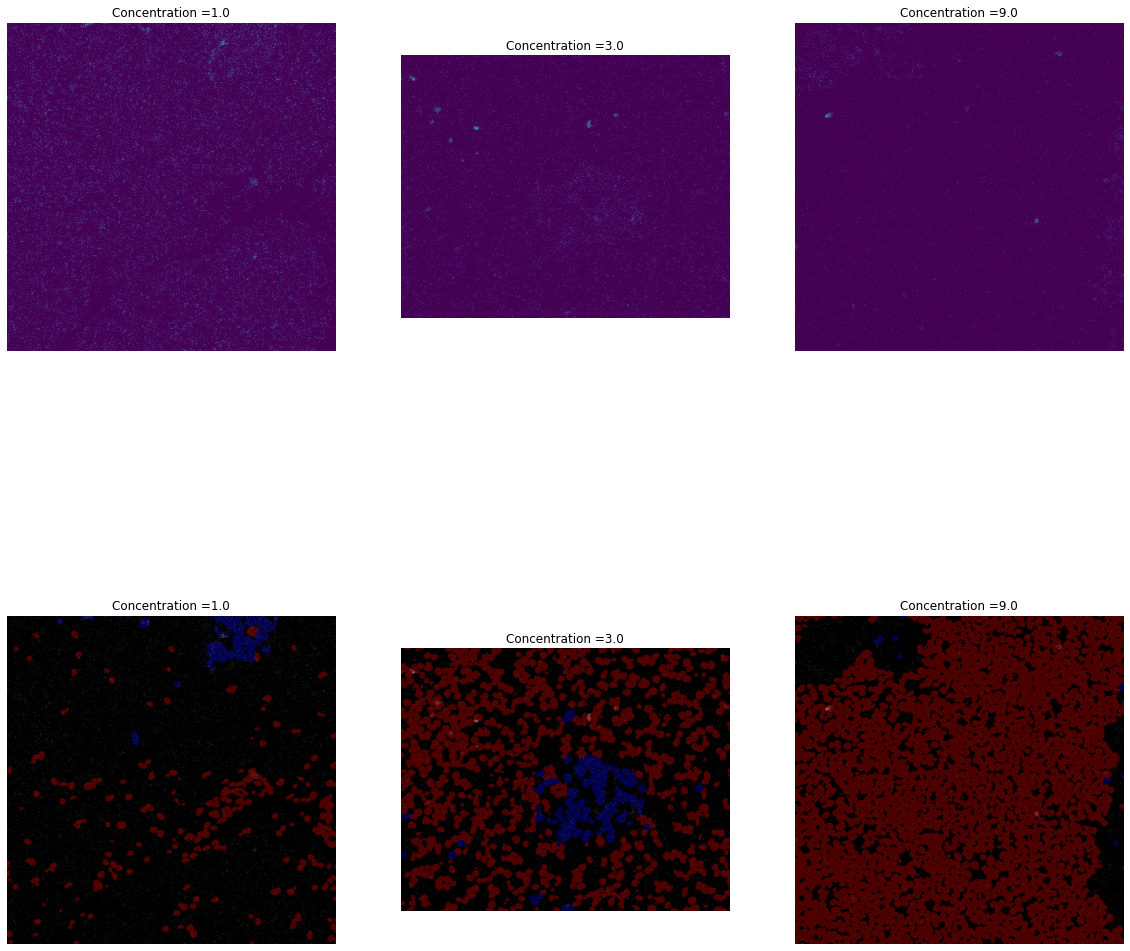

In [370]:
fig, axs = plt.subplots(2, len(concentrations), figsize=(20, 20))

for i, conc in enumerate(concentrations):
    # Images
    cur_image = cv2.convertScaleAbs(image_list[i], alpha=brightness, beta=0)
    cur_image = cur_image[crop_mask[i][0]:crop_mask[i][1], crop_mask[i][2]:crop_mask[i][3]]
    axs[0,i].imshow(cur_image, cmap=plt.cm.viridis)
    axs[0,i].set_title("Concentration =" + str(conc))
    axs[0,i].axis('off')

    # Image-Mask overlay
    overlay = cur_image.copy()
    overlay = skimage.color.gray2rgb(cur_image)
    cur_mask = mask_overlays[i]
    cur_mask = cur_mask[crop_mask[i][0]:crop_mask[i][1], crop_mask[i][2]:crop_mask[i][3]]
    overlay = skimage.color.label2rgb(cur_mask, overlay, alpha=transparency, bg_label=0)
    # axs[i,0].imshow(mask_overlays[i], cmap='RdYlBu_r', alpha=0.5)
    axs[1,i].imshow((overlay*255).astype('uint8'))
    axs[1,i].set_title("Concentration =" + str(conc))
    axs[1,i].axis('off')
    
plt.show()

# 7. Calculate and plot signal and noise

### Calculate signal/noise based on selected clusters

__Retrieve positive and negative cells names__

In [371]:
positive_cells = numpy.empty(len(concentrations)).tolist()
negative_cells = numpy.empty(len(concentrations)).tolist()

for j, conc in enumerate(concentrations):
    ad_subset = ad[ad.obs['concentration'] == conc, ad.var_names == cur_marker]
    positive_cells[j] = ad_subset[ad_subset.obs['cluster_selection'] == 'Positive'].obs_names
    negative_cells[j] = ad_subset[ad_subset.obs['cluster_selection'] == 'Negative'].obs_names

__Calculate average expression levels of positive and negative cells__

In [372]:
signal = []
noise = []

for j, conc in enumerate(concentrations):
    signal.append(np.ndarray.item(
        np.mean(ad[ad.obs_names.isin(positive_cells[j]), cur_marker].layers['exprs'])))
    noise.append(np.ndarray.item(
        np.mean(ad[ad.obs_names.isin(negative_cells[j]), cur_marker].layers['exprs'])))
    
signal = pd.Series(signal, index = concentrations)
noise = pd.Series(noise, index = concentrations)

results = { 'signal': signal, 'noise': noise }
results = pd.DataFrame(results, index=concentrations)

__Calculate signal-to-noise ratio__

In [373]:
# Calculate signal-to-noise ratio
results['SignalToNoise'] = (results['signal'] / results['noise']).astype('float64')

# Adjust variable types
results['marker'] = cur_marker
results['concentration'] = concentrations
results['signal'] = results['signal'].astype('double')
results['noise']  = results['noise'].astype('double')
results['concentration'] = np.array(results['concentration'], dtype='double')

# Transform the dataset
results_long = results.melt(id_vars = ('marker', 'concentration'), var_name='type', value_name='meanExpr')

### Plot the results

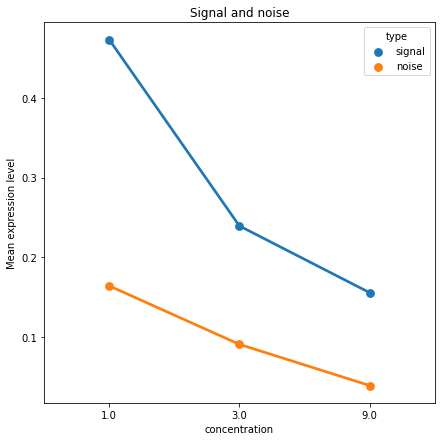

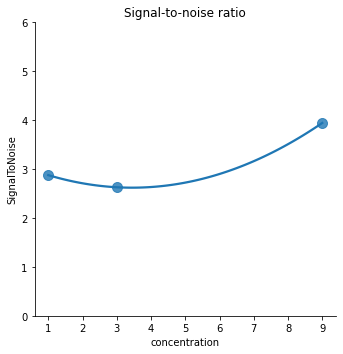

In [374]:
figsize(7,7)
g1 = sns.pointplot(
    data=results_long[(results_long['type'].isin(['signal','noise'])) &
                      (results_long['marker'] == cur_marker)],
    x='concentration', y='meanExpr', hue='type', style='type'
)
g1.set(title="Signal and noise", ylabel="Mean expression level")

cur_results = results[results['marker'] == cur_marker]
g2 = sns.lmplot(
    data = cur_results,
    x='concentration', y='SignalToNoise', col='marker',
    order=2, ci=None, scatter_kws={"s": 100}
)
g2.set(title="Signal-to-noise ratio",
       ylim=(0, 1.5 * math.ceil(max(cur_results['SignalToNoise']))))

# 8. Aggregate and export data


### Define relative concentration for the current marker

Based on the data above, enter the ideal dilution for the current marker.  

In [348]:
final_concentration = 3.0

In [349]:
print("The chosen concentration for marker", cur_marker, "is", final_concentration)

The chosen concentration for marker CDH1 is 3.0


### Aggregate the results

A data frame is created for all the markers. It can be populated by repeating, for each marker, the cluster selection step above (__§6__) and by selecting the ideal concentration using the plots above (__§7__).

In [350]:
titration_results = ad.var.loc[:,('name', 'channel')]
titration_results['selected_dilution'] = None

In [351]:
titration_results.loc[cur_marker, 'selected_dilution'] = final_concentration

### Export the results

When the process has been repeated for all the markers that need to be titrated, the results can exported.

__Final titration results__  
Note that the values are based on the relative concentrations indicated in the mcd file names (or ROI description). The exported numbers ___do not___ represent absolute antibody concentrations.

In [352]:
titration_results

name channel selected_dilution
name                                        
HA              HA   In115              None
WFS1          WFS1   Pr141              None
CHGA          CHGA   Nd142              None
C3              C3   Nd143              None
PCSK2        PCSK2   Nd144              None
XBP1          XBP1   Nd145              None
SYP            SYP   Nd146              None
HIF1A        HIF1A   Sm147              None
pSTAT1      pSTAT1   Nd148              None
ERN1          ERN1   Sm149              None
AMY            AMY   Nd150              None
PFKFB3     PFKFB3    Eu151              None
CPEP          CPEP   Sm152              None
pNRF2        pNRF2   Eu153              None
ProINS      ProINS   Sm154              None
PDX1          PDX1   Gd155              None
ProGCG      ProGCG   Gd156              None
TXNIP        TXNIP   Gd158              None
HSPG          HSPG   Tb159              None
PD_L1        PD_L1   Gd160              None
PTPRN        PTPRN   Dy161              None
CD45          CD45   Dy162              None
NFKB          NFKB   Dy163              None
IDO1         IDO1    Dy164              None
IKBA          IKBA   Ho165              None
ST8SIA1   ST8SIA1    Er166              None
COL1A1      COL1A1   Er167              None
LYVE1       LYVE1    Er168              None
NKX6_1      NKX6_1   Tm169              None
KRT19        KRT19   Er170              None
CD155       CD155    Yb171              None
CDKN1A      CDKN1A   Yb172              None
CDH1          CDH1   Yb173               3.0
pRB            pRB   Lu175              None
SSTR2        SSTR2   Yb176              None
DNA1          DNA1   Ir191              None
DNA3          DNA3   Ir193              None
GHRL          GHRL   Pt195              None
SST            SST   Pt196              None

__Export__

The results are exported as `titration.csv` to the steinbock output directory (defined at the beginning of this script). 

In [127]:
titration_results.to_csv(os.path.join(data_path, 'titration.csv'), index=False)